# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [226]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [227]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/31-01-2022/1000/1000/first"
wantedCSVfilename = "data-batch-vs-acc-1000-1000.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [228]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [229]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [230]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [231]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [232]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [233]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
#     ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
#     ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [234]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'covtypeNorm', 'airlines': 'Airlines'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [235]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


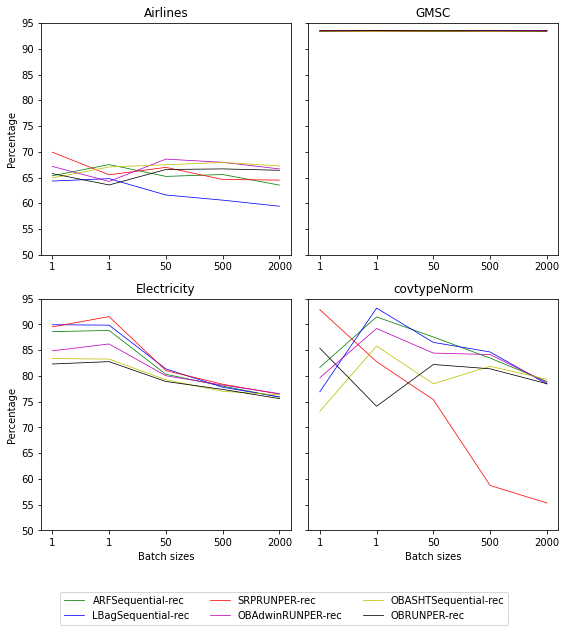

In [236]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


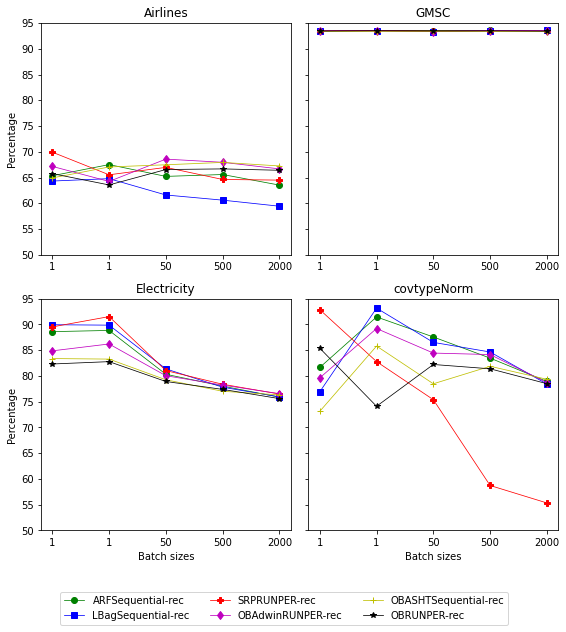

In [237]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
32,airlines,ARFSequential,25,1,1,126.473999,65.347722,63.482181,60.640198
118,airlines,ARFRUNPER,25,1,1,1329.848999,67.510169,63.655300,61.816571
41,airlines,ARFMB,25,50,1,120.730003,65.221622,64.695095,63.929093
55,airlines,ARFMB,25,500,1,120.144997,65.585366,64.473079,63.633120
40,airlines,ARFMB,25,2000,1,124.690002,63.530000,62.415414,61.760395


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
7,airlines,LBagSequential,25,1,1,126.711998,64.317406,57.909592,55.389624
22,airlines,LBagRUNPER,25,1,1,1644.056030,64.783606,61.054078,59.047148
48,airlines,LBagMB,25,50,1,120.128998,61.610526,60.608553,59.747945
57,airlines,LBagMB,25,500,1,120.436996,60.610256,59.266933,58.416950
90,airlines,LBagMB,25,2000,1,123.152000,59.431818,57.201834,56.372306


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
116,airlines,SRPRUNPER,25,1,1,1016.109985,69.924549,65.883348,60.917401
113,airlines,SRPSequential,25,1,1,124.686996,65.532164,64.080498,60.550406
46,airlines,SRPMB,25,50,1,120.140999,66.969072,66.317704,65.146063
16,airlines,SRPMB,25,500,1,121.264999,64.623529,64.566099,63.848363
102,airlines,SRPMB,25,2000,1,123.412003,64.500000,63.465993,62.588949


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
88,airlines,OBAdwinRUNPER,25,1,1,1036.098999,67.160307,64.442719,61.671962
85,airlines,OBAdwinSequential,25,1,1,126.086998,64.244570,62.801668,61.582661
59,airlines,OBAdwinMB,25,50,1,120.027000,68.575092,65.204044,60.378196
44,airlines,OBAdwinMB,25,500,1,120.612000,67.957265,63.563206,60.439188
119,airlines,OBAdwinMB,25,2000,1,120.441002,66.675000,61.821016,59.569798


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
103,airlines,OBASHTSequential,25,1,1,126.343002,64.925439,63.225545,61.653868
66,airlines,OBASHTRUNPER,25,1,1,569.948975,67.054040,66.369994,62.718618
107,airlines,OBASHTMB,25,50,1,120.024002,67.475925,63.834823,60.457663
101,airlines,OBASHTMB,25,500,1,120.011002,67.935319,63.727387,60.279024
33,airlines,OBASHTMB,25,2000,1,120.033997,67.248148,63.168953,59.859891


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,airlines,OBRUNPER,25,1,1,348.020996,65.759135,64.717962,61.652370
86,airlines,OBSequential,25,1,1,127.272003,63.561581,61.861190,60.580296
3,airlines,OBMB,25,50,1,120.469002,66.554738,62.231957,59.988350
91,airlines,OBMB,25,500,1,120.077003,66.676136,62.238015,59.924804
76,airlines,OBMB,25,2000,1,120.605003,66.408491,62.183200,59.769403


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
56,GMSC,ARFSequential,25,1,1,122.301003,93.410045,74.581497,53.419623
14,GMSC,ARFRUNPER,25,1,1,229.326996,93.522000,76.935435,54.402225
23,GMSC,ARFMB,25,50,1,120.013000,93.540464,76.396963,54.334524
28,GMSC,ARFMB,25,500,1,120.109001,93.569796,77.124565,54.547546
19,GMSC,ARFMB,25,2000,1,121.504997,93.556154,76.775340,54.739144


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
77,GMSC,LBagRUNPER,25,1,1,164.934998,93.542000,76.361278,55.403724
35,GMSC,LBagSequential,25,1,1,121.710999,93.491898,74.775666,54.217181
106,GMSC,LBagMB,25,50,1,89.160004,93.341114,72.643458,52.732028
71,GMSC,LBagMB,25,500,1,86.507004,93.484281,76.357312,54.042951
109,GMSC,LBagMB,25,2000,1,90.735001,93.547297,77.609015,54.696593


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
5,GMSC,SRPSequential,25,1,1,122.190002,93.500141,76.572770,51.910527
78,GMSC,SRPRUNPER,25,1,1,464.541992,93.532667,79.943197,53.194926
12,GMSC,SRPMB,25,50,1,120.049004,93.437388,77.780672,52.380030
115,GMSC,SRPMB,25,500,1,120.047997,93.475472,77.099706,52.437766
95,GMSC,SRPMB,25,2000,1,120.313004,93.471250,78.171895,52.283423


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
83,GMSC,OBAdwinRUNPER,25,1,1,86.041000,93.480000,77.540578,53.162077
73,GMSC,OBAdwinSequential,25,1,1,87.339996,93.446000,78.886369,52.111408
72,GMSC,OBAdwinMB,25,50,1,38.483002,93.338446,76.350340,50.498120
74,GMSC,OBAdwinMB,25,500,1,35.430000,93.511037,78.104263,53.565174
97,GMSC,OBAdwinMB,25,2000,1,37.894001,93.489189,78.154960,53.288556


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
49,GMSC,OBASHTRUNPER,25,1,1,82.042999,93.403333,75.5,51.5
24,GMSC,OBASHTSequential,25,1,1,66.278000,93.326667,75.6,51.6
87,GMSC,OBASHTMB,25,50,1,35.615002,93.351784,75.7,51.7
21,GMSC,OBASHTMB,25,500,1,30.493999,93.362542,75.9,51.5
65,GMSC,OBASHTMB,25,2000,1,31.500000,93.345946,75.0,51.6


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
70,GMSC,OBSequential,25,1,1,65.563004,93.446000,78.886369,52.111408
81,GMSC,OBRUNPER,25,1,1,85.565002,93.500000,76.864196,53.959863
34,GMSC,OBMB,25,50,1,38.625999,93.468489,78.330574,52.638168
38,GMSC,OBMB,25,500,1,32.956001,93.478261,77.800047,53.083353
69,GMSC,OBMB,25,2000,1,33.266998,93.417568,78.084715,52.013777


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
36,elecNormNew,ARFSequential,25,1,1,121.620003,88.585176,88.558823,87.835042
11,elecNormNew,ARFRUNPER,25,1,1,112.872002,88.819739,88.787064,88.256554
50,elecNormNew,ARFMB,25,50,1,69.551003,80.307985,80.047600,79.392862
51,elecNormNew,ARFMB,25,500,1,60.979000,78.012586,77.716572,76.914773
79,elecNormNew,ARFMB,25,2000,1,59.165001,75.868120,75.724555,74.423274


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
64,elecNormNew,LBagRUNPER,25,1,1,65.591003,89.927613,89.937878,89.388884
6,elecNormNew,LBagSequential,25,1,1,87.768997,89.845957,89.849325,89.309074
93,elecNormNew,LBagMB,25,50,1,40.263000,81.357430,81.225696,80.367452
45,elecNormNew,LBagMB,25,500,1,35.679001,77.798358,77.496298,76.687188
94,elecNormNew,LBagMB,25,2000,1,34.824001,75.921223,75.720783,74.547927


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
25,elecNormNew,SRPRUNPER,25,1,1,180.328995,89.508298,89.524402,88.938667
105,elecNormNew,SRPSequential,25,1,1,122.302002,91.504382,91.542354,91.183773
75,elecNormNew,SRPMB,25,50,1,120.137001,81.028121,81.050356,79.833978
30,elecNormNew,SRPMB,25,500,1,109.987999,78.374096,78.322080,77.018763
17,elecNormNew,SRPMB,25,2000,1,113.146004,76.475342,76.694541,74.760969


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
39,elecNormNew,OBAdwinSequential,25,1,1,37.294998,84.858316,85.115472,83.780554
53,elecNormNew,OBAdwinRUNPER,25,1,1,39.299999,86.191296,86.277391,85.344993
37,elecNormNew,OBAdwinMB,25,50,1,20.445000,80.027396,80.020725,78.792010
63,elecNormNew,OBAdwinMB,25,500,1,17.309000,78.208962,77.977451,77.041643
110,elecNormNew,OBAdwinMB,25,2000,1,18.868000,76.546915,76.297915,75.302145


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
0,elecNormNew,OBASHTRUNPER,25,1,1,33.733002,83.359816,83.123349,82.668029
15,elecNormNew,OBASHTSequential,25,1,1,30.341000,83.256091,83.118814,82.425905
29,elecNormNew,OBASHTMB,25,50,1,16.773001,79.236446,78.961110,78.243412
108,elecNormNew,OBASHTMB,25,500,1,15.701000,77.006159,76.602605,75.979219
47,elecNormNew,OBASHTMB,25,2000,1,17.318001,76.306797,76.113450,74.966321


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
67,elecNormNew,OBRUNPER,25,1,1,32.671001,82.304908,81.927662,81.787568
82,elecNormNew,OBSequential,25,1,1,27.240999,82.761741,82.461972,82.123155
2,elecNormNew,OBMB,25,50,1,17.006001,78.907251,78.537832,78.038648
20,elecNormNew,OBMB,25,500,1,15.231000,77.372132,76.902691,76.541553
27,elecNormNew,OBMB,25,2000,1,15.966000,75.586443,75.184861,74.472696


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
58,covtypeNorm,ARFSequential,25,1,1,121.458000,81.634195,79.518005,79.117716
9,covtypeNorm,ARFRUNPER,25,1,1,377.884003,91.440143,82.456970,79.482761
54,covtypeNorm,ARFMB,25,50,1,120.028999,87.552283,78.187539,76.352064
100,covtypeNorm,ARFMB,25,500,1,120.146004,83.447619,66.217307,61.719446
96,covtypeNorm,ARFMB,25,2000,1,122.164001,78.914706,57.176957,51.148290


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
112,covtypeNorm,LBagSequential,25,1,1,121.162003,76.903835,77.203128,77.095468
61,covtypeNorm,LBagRUNPER,25,1,1,469.282990,93.152695,82.805538,82.148340
114,covtypeNorm,LBagMB,25,50,1,120.026001,86.500537,79.449150,77.647305
18,covtypeNorm,LBagMB,25,500,1,120.141998,84.634545,72.323241,66.554553
42,covtypeNorm,LBagMB,25,2000,1,124.198997,78.414583,65.926462,59.611905


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
1,covtypeNorm,SRPRUNPER,25,1,1,515.947021,92.856649,87.543262,87.326541
80,covtypeNorm,SRPSequential,25,1,1,121.864998,82.765197,82.870455,81.976422
68,covtypeNorm,SRPMB,25,50,1,120.089996,75.376344,76.093070,75.278354
10,covtypeNorm,SRPMB,25,500,1,120.109001,58.717241,62.455065,58.635709
99,covtypeNorm,SRPMB,25,2000,1,127.110001,55.327778,56.598261,51.673150


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
31,covtypeNorm,OBAdwinSequential,25,1,1,120.944000,79.611913,74.560177,75.041227
13,covtypeNorm,OBAdwinRUNPER,25,1,1,277.959991,89.192138,80.776828,79.973557
117,covtypeNorm,OBAdwinMB,25,50,1,120.035004,84.425017,75.837868,73.849328
84,covtypeNorm,OBAdwinMB,25,500,1,120.195000,84.136000,68.305596,66.493600
98,covtypeNorm,OBAdwinMB,25,2000,1,121.242996,78.706579,62.134903,57.434135


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
111,covtypeNorm,OBASHTSequential,25,1,1,120.584000,73.115307,67.844635,70.743970
26,covtypeNorm,OBASHTRUNPER,25,1,1,221.481995,85.785115,71.921637,74.572383
52,covtypeNorm,OBASHTMB,25,50,1,120.000999,78.463654,68.124625,69.891375
43,covtypeNorm,OBASHTMB,25,500,1,120.181999,81.857754,65.551703,63.832535
89,covtypeNorm,OBASHTMB,25,2000,1,121.357002,79.335841,61.247339,56.733976


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
92,covtypeNorm,OBRUNPER,25,1,1,216.718994,85.373442,71.805134,74.332827
62,covtypeNorm,OBSequential,25,1,1,120.408997,74.096421,67.791872,70.801329
104,covtypeNorm,OBMB,25,50,1,120.022003,82.209869,69.230925,70.759349
8,covtypeNorm,OBMB,25,500,1,120.242996,81.370330,65.442103,63.521849
4,covtypeNorm,OBMB,25,2000,1,120.350998,78.482927,61.828426,56.726386


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


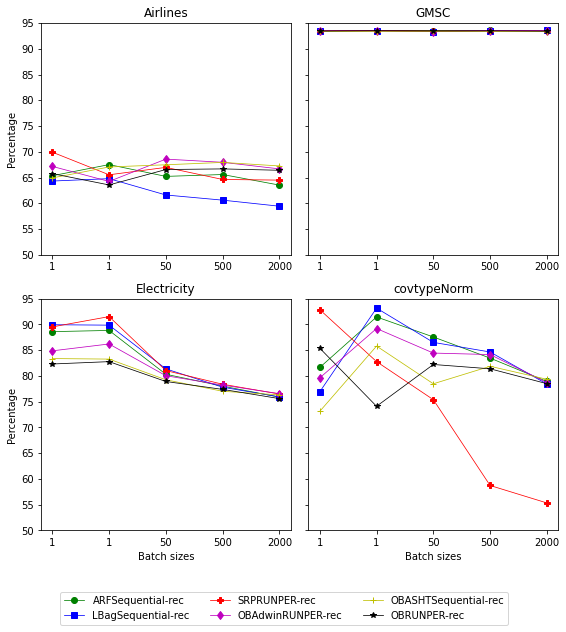

In [238]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)